<a href="https://colab.research.google.com/github/MattHodgman/ProteoHist/blob/main/make_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install slideio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.4 MB 176 kB/s 


In [ ]:
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from PIL import Image
import random
from google.colab.patches import cv2_imshow
import matplotlib.cm as cm
import matplotlib
import pandas as pd
import slideio
import pickle

In [ ]:
def make_heat_map(slide, df, orig_height, group, protein, cmapper, show=False, save=False):

  file_name = slide + '.h5'
  coords = df[df['file_name'] == file_name][['x','y']].to_numpy()
  expression_values = df[df['file_name'] == file_name][protein].to_numpy().reshape(-1, 1)

  cv2_img = cv2.imread(f'/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/{group}/stitches/{slide}.jpg')

  scaling = orig_height // cv2_img.shape[0]
  size = 256 // scaling

  # Initialize blank mask image of same dimensions for drawing the shapes
  shapes = np.zeros_like(cv2_img, np.uint8)

  # Draw shapes
  for i in range(coords.shape[0]):
    x = int(coords[i,0] // scaling)
    y = int(coords[i,1] // scaling)
    c = tuple([int(255*x) for x in cmapper.to_rgba(expression_values[i][0])[:-1]])
    
    cv2.rectangle(shapes, (x, y), (x+size, y+size), color=c, thickness=-1)

  out = cv2_img.copy()
  alpha = 0.3
  mask = shapes.astype(bool)
  out[mask] = cv2.addWeighted(cv2_img, alpha, shapes, 1 - alpha, 0)[mask]

  # Visualization
  if show:
    print(slide, group)
    cv2_imshow(out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  if save:
    cv2.imwrite(f'/content/drive/MyDrive/BIOINF_590/Data/Images/heat_maps/{group}/{slide}.jpg', out)


def get_original_height(slide, group):
  slide = slideio.open_slide(f'/content/drive/MyDrive/BIOINF_590/Data/Images/raw_images/{group}/{slide}.svs',"SVS")
  raw_string = slide.raw_metadata
  height = int([x for x in raw_string.split("|") if 'OriginalHeight' in x][0].split('= ')[1])
  return height

def get_group(slide):
  groups = ['normal', 'tumor', 'both']
  for group in groups:
    path = f'/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/{group}/stitches/'
    dir_list = os.listdir(path)
    slides = [f.split('.')[0] for f in dir_list]
    if slide in slides:
      return group

def make_cmapper(df, protein):
  expression_values = df[protein].to_numpy().reshape(-1, 1)
  minima = min(expression_values)
  maxima = max(expression_values)
  # norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
  norm = matplotlib.colors.DivergingNorm(vcenter=-0.12685, vmin=minima, vmax=maxima)
  cmapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
  return cmapper

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/PredictedPatchExpression/all_slides_RTKN.csv')

In [ ]:
# add group to df
df['slide'] = df['file_name'].apply(lambda x: x.split('.')[0])

group_map = {}
for slide in df['slide'].unique():
  group_map[slide] = get_group(slide)
  
df['group'] = df['slide'].map(group_map)

In [ ]:
# df.to_csv('/content/drive/MyDrive/BIOINF_590/Data/PredictedPatchExpression/slide_patch_expression_table.csv', index=False)

In [ ]:
import seaborn as sns

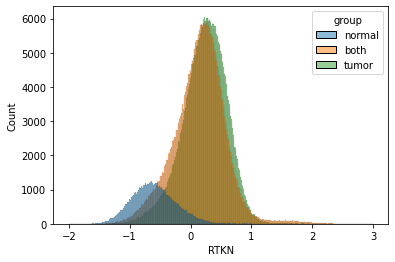

In [ ]:
sns.histplot(data=df, x='RTKN', hue='group')

In [ ]:
protein = 'RTKN'
cmapper = make_cmapper(df, protein)
for slide in df['slide'].unique():
  group = get_group(slide)
  orig_height = get_original_height(slide, group)
  make_heat_map(slide, df, orig_height, group, protein, cmapper, show=False, save=True)

<ipython-input-47-47592b675002>:59: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = matplotlib.colors.DivergingNorm(vcenter=-0.12685, vmin=minima, vmax=maxima)
